In [1]:
from aux import compute_graphs, print_and_analyze_graph, construct_program
import aux

import re

import networkx as nx
import matplotlib.pyplot as plt

import clingo
from clingox.reify import reify_program

## Phase 0
(Start from a previously found graph for phase 1, if desired.)

In [2]:
gen_program = None

## Phase 1

In [3]:
num_nodes = 12

if not gen_program:
    # Generate any graph with the given number of nodes
    gen_program = f"""
        #const n={num_nodes}.
    """
    gen_program += """
        node(1..n).
        { edge(X,Y) } :- node(X), node(Y), X != Y.
        edge(X,Y) :- edge(Y,X).
    """


program = construct_program(
    gen_program,
    max_indset_lower = 4,
    max_indset_upper = 6,
    min_domset_size = 4,
    sym_breaking = False,
    require_3col = True,
    require_ham_cycle = True,
    require_planar = True,
    forbid_2col = False,
    require_ids_larger_than_ds = True,
)

In [4]:
graphs = compute_graphs(
    program,
    verbose=True,
    num_models=1,
)

.. Grounding ..
.. Solving ..
.
.. Done solving ..
Total solving time: 38.76 sec


GRAPH: node(1). node(2). node(3). node(4). node(5). node(6). node(7). node(8). node(9). node(10). node(11). node(12). edge(10,1). edge(11,1). edge(4,2). edge(12,2). edge(5,3). edge(10,3). edge(11,3). edge(2,4). edge(5,4). edge(7,4). edge(3,5). edge(4,5). edge(8,5). edge(8,6). edge(10,6). edge(4,7). edge(9,7). edge(12,7). edge(5,8). edge(6,8). edge(9,8). edge(10,8). edge(11,8). edge(7,9). edge(8,9). edge(1,10). edge(3,10). edge(6,10). edge(8,10). edge(1,11). edge(3,11). edge(8,11). edge(2,12). edge(7,12).
 - Num nodes: 12
 - Num edges: 17
 - Min VC size: 6
 - Min DS size: 4
 - Max IS size: 6
 - Min IDS size: 5
 - Has Hamiltonian cycle: True
 - Is 2-colorable: False
 - Is 3-colorable: True
 - Degree: 5


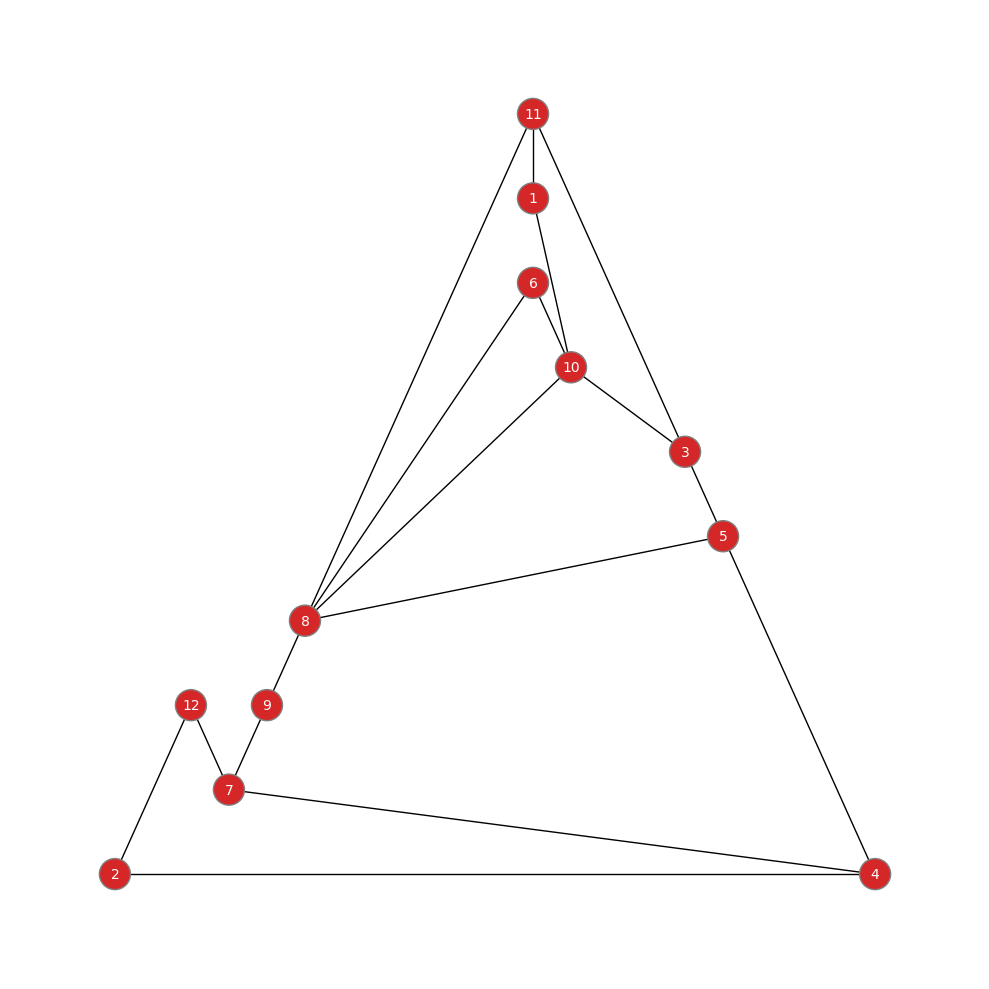

In [5]:
for graph in graphs:
    print_and_analyze_graph(graph)

## Phase 2

In [22]:
nodes, edges = aux.get_list_repr_of_graph(graphs[0])
nx_graph = nx.Graph()
nx_graph.add_nodes_from(nodes)
nx_graph.add_edges_from(edges)
is_planar, embedding = nx.check_planarity(nx_graph)

if is_planar:
    faces = set()
    for node1, node2 in edges:
        face = frozenset(embedding.traverse_face(node1, node2))
        faces.add(face)
else:
    print("ERROR: Graph is not planar!")

# Generate program based on planar embedding of previous graph
gen_program = ""
for node in nodes:
    gen_program += f"big_node({node}).\n"
for node1, node2 in edges:
    gen_program += f"big_edge({node1},{node2}).\n"
num_nodes = max(nodes)

for face_num, face in enumerate(faces, 1):
    node_nr = num_nodes + face_num
    gen_program += f"pos_node({node_nr}).\n"
    for node in face:
        gen_program += f"pos_edge({node_nr}, {node}).\n"

# Minimum number of nodes to add
min_num_new_nodes = 7
max_num_new_nodes = None

gen_program += """
    node(X) :- big_node(X).
    edge(X,Y) :- big_edge(X,Y).
    edge(X,Y) :- edge(Y,X).

    { edge(X,Y) : pos_edge(X,Y) }.
    node(X) :- pos_node(X), edge(X,_).
"""
if min_num_new_nodes:
    gen_program += f"""
        % Enough new nodes
        :- not {min_num_new_nodes} {{ node(X) : pos_node(X) }}.
    """
if max_num_new_nodes:
    gen_program += f"""
        % Enough new nodes
        :- not {{ node(X) : pos_node(X) }} {max_num_new_nodes}.
    """

program2 = construct_program(
    gen_program,
    max_indset_lower = 8,
    max_indset_upper = 10,
    min_domset_size = 5,
    sym_breaking = False,
    require_3col = True,
    require_ham_cycle = True,
    require_planar = False, # no need to check, by construction planar
    forbid_2col = False,
    require_ids_larger_than_ds = True,
)

In [23]:
graphs2 = compute_graphs(
    program2,
    verbose=True,
    num_models=1,
)

.. Grounding ..
.. Solving ..
.
.. Done solving ..
Total solving time: 0.07 sec


GRAPH: big_node(1). big_node(2). big_node(3). big_node(4). big_node(5). big_node(6). big_node(7). big_node(8). big_node(9). big_node(10). big_node(11). big_node(12). node(1). node(2). node(3). node(4). node(5). node(6). node(7). node(8). node(9). node(10). node(11). node(12). node(13). node(14). node(15). node(16). node(17). node(18). node(19). edge(10,1). edge(11,1). edge(4,2). edge(12,2). edge(5,3). edge(10,3). edge(11,3). edge(2,4). edge(5,4). edge(7,4). edge(3,5). edge(4,5). edge(8,5). edge(8,6). edge(10,6). edge(4,7). edge(9,7). edge(12,7). edge(5,8). edge(6,8). edge(9,8). edge(10,8). edge(11,8). edge(7,9). edge(8,9). edge(1,10). edge(3,10). edge(6,10). edge(8,10). edge(1,11). edge(3,11). edge(8,11). edge(2,12). edge(7,12). edge(13,10). edge(13,6). edge(14,2). edge(14,12). edge(14,7). edge(15,3). edge(15,1). edge(15,10). edge(15,11). edge(16,4). edge(16,8). edge(17,1). edge(17,6). edge(18,2). edge(18,3). edge(18,11). edge(19,10). edge(19,3). edge(19,5). edge(5,19). edge(3,19). edg

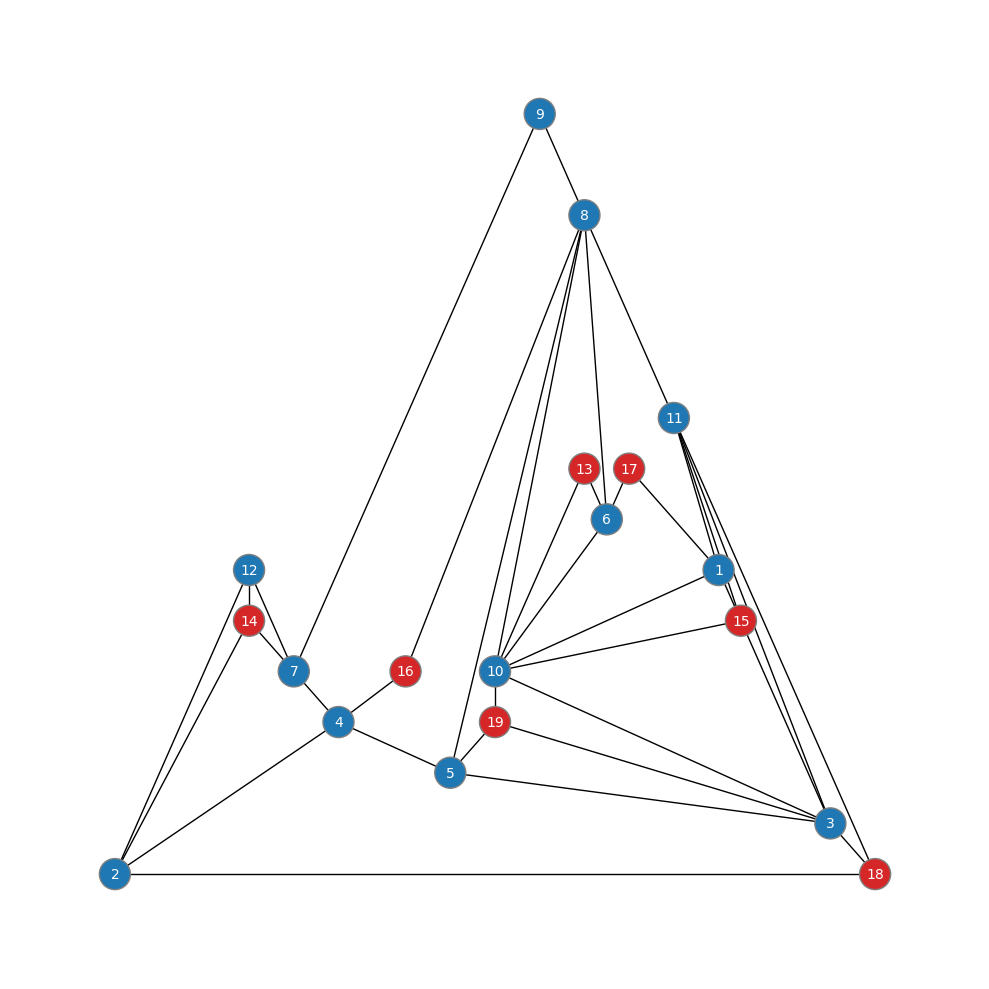

In [24]:
for graph in graphs2:
    print_and_analyze_graph(graph)